<a href="https://colab.research.google.com/github/abulhasanat/NLP-Experiments/blob/master/customer_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

     |████████████████████████████████| 778kB 4.5MB/s 
     |████████████████████████████████| 890kB 20.0MB/s 
     |████████████████████████████████| 3.0MB 31.0MB/s 
     |████████████████████████████████| 1.1MB 54.0MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=29669b0d2b1bbd07ee4dc0c71c21cd6e2a56fc3d6db1e5fe76dea3613eecda5d
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


device(type='cuda', index=0)

In [3]:
df = pd.read_excel("/content/drive/My Drive/Training data/IT_Clients_Website_Data_all.xlsx")
df.head()

,Name,Website,WIP RANGE,Links in Websites,Text in Websites
0,Paragon Solutions Inc.,http://www.consultparagon.com,High,['http://www.cgi.com/en/mergers'],Life Sciences US CGI United States Skip main ...
1,"Unify Energy Solutions, LLC - Houston",http://www.unifytexas.com,High,['http://unifyes.com'],Modern Green Efficiency Solutions Unify Energ...
2,Blue Ridge Networks,http://blueridge.com/,High,[],Blue Ridge Networks Preventative Cybersecurity...
3,"Mainline Information Systems, Inc.",http://www.mainline.com,High,"['http://mainline.com/contact-us/', 'http://ma...",Mainline Information Systems IT Solutions Ma...
4,Concord USA,https://concordusa.com/,High,[],Home Page Concord Skip main content Primary N...


In [4]:
def get_client_type(Wip_range):
    if Wip_range in ['Large','High','Medium']:
        return 'Good'
    else:
        return 'Bad'

In [5]:
df['Client_Type']=df['WIP RANGE'].apply(lambda x: get_client_type(x))
df.head()

,Name,Website,WIP RANGE,Links in Websites,Text in Websites,Client_Type
0,Paragon Solutions Inc.,http://www.consultparagon.com,High,['http://www.cgi.com/en/mergers'],Life Sciences US CGI United States Skip main ...,Good
1,"Unify Energy Solutions, LLC - Houston",http://www.unifytexas.com,High,['http://unifyes.com'],Modern Green Efficiency Solutions Unify Energ...,Good
2,Blue Ridge Networks,http://blueridge.com/,High,[],Blue Ridge Networks Preventative Cybersecurity...,Good
3,"Mainline Information Systems, Inc.",http://www.mainline.com,High,"['http://mainline.com/contact-us/', 'http://ma...",Mainline Information Systems IT Solutions Ma...,Good
4,Concord USA,https://concordusa.com/,High,[],Home Page Concord Skip main content Primary N...,Good


In [6]:
def clean_col(col, kw_to_drop='Item'):
    kw_to_drop = str.lower(kw_to_drop)+' ' if ' 'in kw_to_drop else str.lower(kw_to_drop)
    new_col = ''.join(str.lower(col).split(kw_to_drop))
    new_col = '_'.join(new_col.split(' '))
    new_col = new_col.replace('date_&_time', 'timestamp')
    if new_col[0] == '_':
        new_col = new_col[1:]
    return new_col

In [7]:
df.columns = pd.Series(df.columns).apply(lambda x: clean_col(x, kw_to_drop='incident'))

In [8]:
df.head()

,name,website,wip_range,links_in_websites,text_in_websites,client_type
0,Paragon Solutions Inc.,http://www.consultparagon.com,High,['http://www.cgi.com/en/mergers'],Life Sciences US CGI United States Skip main ...,Good
1,"Unify Energy Solutions, LLC - Houston",http://www.unifytexas.com,High,['http://unifyes.com'],Modern Green Efficiency Solutions Unify Energ...,Good
2,Blue Ridge Networks,http://blueridge.com/,High,[],Blue Ridge Networks Preventative Cybersecurity...,Good
3,"Mainline Information Systems, Inc.",http://www.mainline.com,High,"['http://mainline.com/contact-us/', 'http://ma...",Mainline Information Systems IT Solutions Ma...,Good
4,Concord USA,https://concordusa.com/,High,[],Home Page Concord Skip main content Primary N...,Good


In [9]:
df1=df[df['text_in_websites']!='Error']
df1.head()

,name,website,wip_range,links_in_websites,text_in_websites,client_type
0,Paragon Solutions Inc.,http://www.consultparagon.com,High,['http://www.cgi.com/en/mergers'],Life Sciences US CGI United States Skip main ...,Good
1,"Unify Energy Solutions, LLC - Houston",http://www.unifytexas.com,High,['http://unifyes.com'],Modern Green Efficiency Solutions Unify Energ...,Good
2,Blue Ridge Networks,http://blueridge.com/,High,[],Blue Ridge Networks Preventative Cybersecurity...,Good
3,"Mainline Information Systems, Inc.",http://www.mainline.com,High,"['http://mainline.com/contact-us/', 'http://ma...",Mainline Information Systems IT Solutions Ma...,Good
4,Concord USA,https://concordusa.com/,High,[],Home Page Concord Skip main content Primary N...,Good


Text(0.5, 0, 'Client Type')

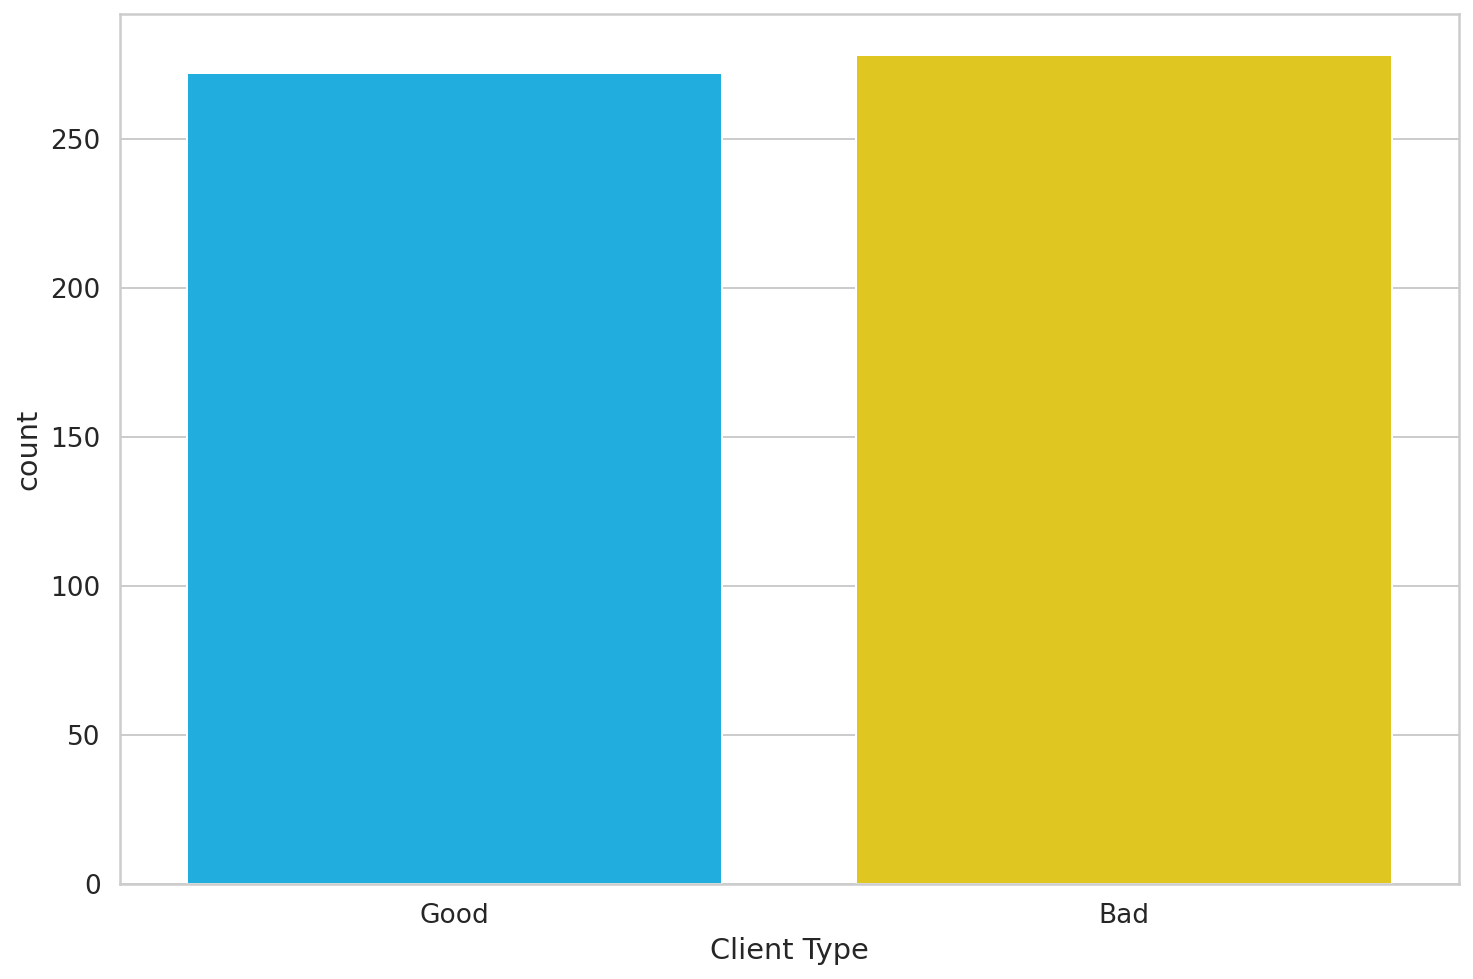

In [10]:
sns.countplot(df1.client_type)
plt.xlabel('Client Type')

In [ ]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [13]:
MAX_LEN = 160

In [14]:
class GPReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]

    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [15]:
df_train, df_test = train_test_split(df1, test_size=0.1, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

In [16]:
df_train.shape, df_val.shape, df_test.shape

((495, 6), (27, 6), (28, 6))

In [17]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = GPReviewDataset(
    reviews=df.text_in_websites.to_numpy(),
    targets=df.client_type.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [18]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [23]:
MAX_LEN

160

In [21]:
data = next(iter(train_data_loader))
data.keys()

Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Truncation was not explicitely activated but `max_length` is provided a specific value, please use `truncation=True` to explicitely truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (

TypeError: ignored

In [19]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [20]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

NameError: ignored